# Let's build a spam classifier

We will use df from `SMS Spam Collection v. 1` described as:

> a public set of SMS labeled messages that have been collected for mobile phone spam research. It has one collection composed by 5,574 English, real and non-encoded messages, tagged according being legitimate (ham) or spam.

([source](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/))

#### Load useful libraries and df

In [171]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from tqdm import tqdm

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/janice/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/janice/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [172]:
# Load df
df = pd.read_csv(
    "../data/ChatGPT-play-reviews_prep.csv",
    encoding="utf-8",
)

# var for review received response
df["score_cat"] = np.where(df.score == 5, "positive", np.where(df.score == 4, "neutral", "negative"))

In [173]:
# Looking at a sample of our df
df.sample(10)

### CountVectorizer

In [176]:
# Fit the CountVectorizer to the training df
vect = CountVectorizer().fit(df['content'])

# transform the documents in the training df to a document-term matrix
X_train_vectorized = vect.transform(df['content'])
# print("X_train_vectorized: ", X_train_vectorized)

In [177]:
print("X_train shape = {}".format(df['content'].shape))
print("Vocabulary length = {}".format(len(vect.vocabulary_)))

X_train shape = (30956,)
Vocabulary length = 15245


So in 30.956 messages we found 15.245 different words.

In [178]:
# Let's look at our vocabulary list (sorted alphabetically)
# Does it look like you expected?
sorted(vect.vocabulary_.items(), key=lambda x: x[1])[200:240]

[('5g', 200),
 ('5he', 201),
 ('5k', 202),
 ('5lacs', 203),
 ('5m', 204),
 ('5mb', 205),
 ('5o', 206),
 ('5star', 207),
 ('5stars', 208),
 ('5th', 209),
 ('60', 210),
 ('600', 211),
 ('62851', 212),
 ('64', 213),
 ('64th', 214),
 ('65', 215),
 ('68', 216),
 ('69', 217),
 ('6a', 218),
 ('6th', 219),
 ('70', 220),
 ('750', 221),
 ('777ffmahima', 222),
 ('78898', 223),
 ('7a', 224),
 ('7c', 225),
 ('7ec556a4dde829ea', 226),
 ('7ec5c6a5eb2dfb28', 227),
 ('7p', 228),
 ('7sdni', 229),
 ('7th', 230),
 ('7yati', 231),
 ('80', 232),
 ('800', 233),
 ('80286', 234),
 ('80mbps', 235),
 ('819', 236),
 ('838', 237),
 ('84', 238),
 ('841', 239)]

In [181]:
# # get the feature names as numpy array
# feature_names = np.array(vect.get_feature_names_out())

# # Sort the coefficients from the model (from lowest to highest values)
# sorted_coef_index = model.coef_[0].argsort()

# # Find the 10 smallest and 10 largest coefficients
# # The 10 largest coefficients are being indexed using [:-11:-1]
# # so the list returned is in order of largest to smallest
# print("Smallest Coefs:\n{}\n".format(feature_names[sorted_coef_index[:10]]))
# print("Largest Coefs: \n{}".format(feature_names[sorted_coef_index[:-11:-1]]))

The AUC of our first model was already pretty good (~0.95). Let's see if we can improve this with another transformation of our df. Therefore, we will test the TF-IDF transformation next.




### TF-IDF

TF-IDF is short for **Term Frequency - Inverse Document Frequency**. 

It measure how important a word is to a document in a set of texts (in our case all SMS we collected). A frequent word in a document that is also frequent in the corpus is less important to a document than a frequent word in a document that is not frequent in the corpus.




In [182]:
# Fit the TfidfVectorizer to the training df specifiying a minimum document frequency of 30
# This means a word should have been used in at least 30 reviews
vect = TfidfVectorizer(min_df=30).fit(df['content'])

# transform the documents in the training df to a document-term matrix
X_train_vectorized = vect.transform(df['content'])

# let's look of some of the words gathered with this method
sorted(vect.vocabulary_.items(), key=lambda x: x[1])[10:30]

KeyboardInterrupt: 

In [ ]:
# how many words appear in more than 20 text messages
len(sorted(vect.vocabulary_.items(), key=lambda x: x[1]))

1010

We can check which words created the largest tfidf values for the texts.

In [ ]:
# save all feature names == words in an array
feature_names = np.array(vect.get_feature_names_out())

#sort for the column names according to highest tfidf value in the column
sorted_tfidf_index = X_train_vectorized.toarray().max(0).argsort()

# print words with highest and lowest tfidf values
print("Smallest tfidf:\n{}\n".format(feature_names[sorted_tfidf_index[:10]]))
print("Largest tfidf: \n{}".format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['exceeded' 'processing' 'consistently' 'versatility' 'powered' 'coherent'
 'natural' 'however' 'whether' 'interactions']

Largest tfidf: 
['কর' 'size' 'kudos' 'la' 'language' 'learning' 'let' 'level' 'life'
 'like']


### Stemming

Stemming reduces a word to its stem. The result is less readable to humans, but makes the text more comparable across observations.

For example, the words "consult", "consultant", "consulting", " consultative", "consultants" have the same stem **"consult "**.

We will now add stemming as a preprocessing step to our workflow. The nltk PorterStemmer will generate the stems of the words. These features will be used in the CountVectorizer to create a matrix with the number of features (stemmed words).

In [ ]:
# Initializing stemmer and countvectorizer 
stemmer = nltk.PorterStemmer()
cv_analyzer = CountVectorizer().build_analyzer()
# tfidf_analyzer = TfidfVectorizer(min_df=15).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in cv_analyzer(doc))

# define CountVectorizer with stemming function 
stem_vectorizer = CountVectorizer(analyzer = stemmed_words)
# stem_vectorizer = TfidfVectorizer(min_df=15, analyzer = stemmed_words)


# Transform X_train
df_content_stem_vectorized = stem_vectorizer.fit_transform(df['content'])

In [ ]:
r = 300
sample_text = X_train[r:r+1]
print("Sample Text - ", sample_text[sample_text.index[0]])
print("-"*30)
print("Text after passing through build_analyzer - ", cv_analyzer(sample_text[sample_text.index[0]]))
print("-"*30)
print("Text after stemming - ",[stemmer.stem(w) for w in cv_analyzer(sample_text[sample_text.index[0]])])


Sample Text -  I'm really amazed 👏 this kind of ai also exists in the world 😇
------------------------------
Text after passing through build_analyzer -  ['really', 'amazed', 'this', 'kind', 'of', 'ai', 'also', 'exists', 'in', 'the', 'world']
------------------------------
Text after stemming -  ['realli', 'amaz', 'thi', 'kind', 'of', 'ai', 'also', 'exist', 'in', 'the', 'world']


You can also try uncommenting the tfidf lines in the cell above, so instead of using CountVectorizer you can also use TfIDF

### Lemmatization

The same way we used stemming we can also apply lemmatization to our df.
Lemmatization reduces variant forms to base form (eg. am, are, is --> be; car, cars, car's, cars' --> car).


In [ ]:
# Initialization
WNlemma = nltk.WordNetLemmatizer()
cv_analyzer = CountVectorizer().build_analyzer()
# cv_analyzer = TfidfVectorizer(min_df=15).build_analyzer()

def lemmatize_word(doc):
    return (WNlemma.lemmatize(t) for t in cv_analyzer(doc))

lemm_vectorizer = CountVectorizer(analyzer = lemmatize_word)
# lemm_vectorizer = TfidfVectorizer(min_df=15, analyzer=lemmatize_word)

# Transform X_train
df_content_lemm_vectorized = lemm_vectorizer.fit_transform(df['content'])

In [ ]:
df_content_lemm_vectorized.shape

(30956, 14215)

In [ ]:
r = 500
sample_text = X_train[r:r+1]
print("Sample Text - ", sample_text[sample_text.index[0]])
print("-"*30)
print("Text after passing through build_analyzer - ", cv_analyzer(sample_text[sample_text.index[0]]))
print("-"*30)
print("Text after stemming - ",[WNlemma.lemmatize(t) for t in cv_analyzer(sample_text[sample_text.index[0]])])

Sample Text -  🥰🥰⚡ ⚡🔥🔥
------------------------------
Text after passing through build_analyzer -  []
------------------------------
Text after stemming -  []


In [ ]:
nltk.download('punkt')  # Download the punkt tokenizer data

# Function to split text into sentences
def split_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return sentences

# Split sentences and create a new DataFrame in long format
new_rows = []
for index, row in df.iterrows():
    sentences = split_sentences(row['content'])
    score = row['score']
    score_cat = row['score_cat']
    for sentence in sentences:
        new_rows.append({'index': index, 'content': sentence, 'score': score, 'score_cat': score_cat})

df_long = pd.DataFrame(new_rows)

# Print the resulting DataFrame in long format
print(df_long[df_long['index'] == 5])

[nltk_data] Downloading package punkt to /Users/janice/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


    index  \
21      3   
22      3   
23      3   
24      3   
25      3   

                                                                             content  \
21                             No subscription, free and accurate, unbiased answers.   
22  No fresh data since September 2021 but that doesn't make this app less accurate.   
23    I'm loving the fact it can even generate basic ASCII ART other than just text.   
24        The text is excellent, grammar precise and a great plethora of vocabulary.   
25                     I can't wait for the next update and to see what that brings.   

    score score_cat  
21      5  positive  
22      5  positive  
23      5  positive  
24      5  positive  
25      5  positive  


In [ ]:
pd.set_option('display.max_colwidth', None)
print(df_long[df_long['index'] == 5].content)
#print(df[df.index == 3].content)

38                                                                                                                                                     Seems to work now.
39                                                                                                                                     App seems nice but has two issues.
40    The website mentions that users can enable voice conversations in "Settings → App → New Features → Voice conversations (toggle on)" but this setting doesn't exist.
41            Also, when using voice dictation to compose a prompt, it writes mandarin text using simplified characters rather than standard form/traditional characters.
Name: content, dtype: object


In [ ]:
from transformers import pipeline
import torch

In [ ]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.2.0.dev20231024
Is CUDA enabled? False


In [328]:
#candidate_labels = ["feature evaluation", "praise", "bug report", "feature request", "performance", "usage"]
candidate_labels = ["positive", "neutral", "negative"]
hypothesis_template = "The sentiment of this review is {}."

In [339]:
#candidate_labels = list(category_map.values())
predictedCategories = []
ScoreNegative = []
ScoreNeutral = []
ScorePositive = []

for i in tqdm(range(1000)):
    text = df_long.iloc[i,]['content']
    res = classifier(text, candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)
    labels = res['labels'] 
    scores = res['scores'] #extracting the scores associated with the labels
    res_dict = {label : score for label,score in zip(labels, scores)}
    sorted_dict = dict(sorted(res_dict.items(), key=lambda x:x[1],reverse = True)) #sorting the dictionary of labels in descending order based on their score
    categories  = next(k for i, (k,v) in enumerate(sorted_dict.items()))

    ScorePositive.append(sorted_dict['positive'])
    ScoreNeutral.append(sorted_dict['neutral'])
    ScoreNegative.append(sorted_dict['negative'])
    predictedCategories.append(categories)

100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s]


In [340]:
dataset_prep = pd.DataFrame({'category': predictedCategories, 
                             'positive_score': ScorePositive, 
                             'neutral_score': ScoreNeutral, 
                             'negative_score': ScoreNegative})
dataset = pd.merge(df_long, dataset_prep, left_index=True, right_index=True)

In [341]:
dataset

,index,content,score,score_cat,category,positive_score,neutral_score,negative_score
0,0,"ChatGPT on Android is a solid app with seamless OpenAI server connectivity, ensuring smooth interactions.",4,neutral,positive,0.999617,0.399917,0.000733
1,0,"However, it falls behind its Apple counterpart in features and updates.",4,neutral,negative,0.016458,0.719351,0.980443
2,0,"The voice input can be prematurely triggered by pauses, unlike on Apple.",4,neutral,negative,0.691213,0.317877,0.729095
3,0,"Additionally, the lack of a search function for previous messages is a drawback.",4,neutral,negative,0.000823,0.238583,0.977248
4,0,"Despite these, it remains a commendable app, deserving a 4-5 star rating.",4,neutral,positive,0.998948,0.003366,0.001539
...,...,...,...,...,...,...,...,...
995,201,Still a great tool.,3,negative,positive,0.999366,0.470242,0.001341
996,201,Needs to improve to be worth subscription money.,3,negative,negative,0.003718,0.662778,0.972756
997,202,"ChatGPT is really helpful in many cases, especially when you need some rare knowledge.",5,positive,positive,0.998024,0.021908,0.000630
998,202,"I use it for cooking, for computer programming, for writing high quality text documents, and for everything else.",5,positive,positive,0.933658,0.117617,0.005446


predictedCategories

In [333]:
pd.set_option('max_colwidth', 700)
dataset.sort_values('category', ascending=True)

,index,content,score,score_cat,category,positive_score,neutral_score,negative_score
605,116,But the app lacks many of the functionality of the browser-based version.,3,negative,negative,0.025535,0.713079,0.961945
494,95,And After that I have to restart app to again write message,5,positive,negative,0.084329,0.205954,0.585535
495,96,I've not been able to run this app so my review is only based on the very little interaction I have had with it.,1,negative,negative,0.213217,0.761041,0.862705
268,49,It's initial login/setup screen used the default BRIGHT WHITE high contrast scheme that is very painful for me,3,negative,negative,0.001557,0.061183,0.962123
267,49,"However, that only kicked in after I had logged in after installation.",3,negative,negative,0.295070,0.494392,0.706550
...,...,...,...,...,...,...,...,...
392,72,"I've found it extremely helpful for generating examples to illustrate new concepts, and it's often simpler to ask ChatGPT than to ask Google",5,positive,positive,0.999472,0.007115,0.000325
393,73,I love the voice control SO much!,5,positive,positive,0.999081,0.004470,0.000640
395,74,Very useful for learning.,5,positive,positive,0.998812,0.150690,0.000685
398,74,"There are many other uses for this app, but just asking questions about various topics is my favorite use.",5,positive,positive,0.975549,0.136075,0.001041


In [342]:
dataset.groupby('category').mean('category')

,index,score,positive_score,neutral_score,negative_score
category,,,,,
negative,101.465672,3.567164,0.104415,0.277386,0.810981
neutral,71.857143,3.964286,0.275094,0.572316,0.236319
positive,94.989011,4.563579,0.926385,0.175053,0.045800


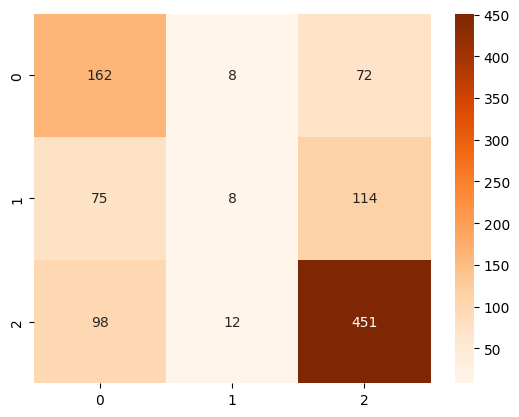

In [343]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


#Confusion matrix using pandas crosstab
conf_matrix = confusion_matrix(dataset.score_cat, dataset.category)
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Oranges, fmt='g'); 

Aggregating on review level

In [344]:
dataset = pd.get_dummies(dataset, columns=["category"], dtype=int)
dataset

,index,content,score,score_cat,positive_score,neutral_score,negative_score,category_negative,category_neutral,category_positive
0,0,"ChatGPT on Android is a solid app with seamless OpenAI server connectivity, ensuring smooth interactions.",4,neutral,0.999617,0.399917,0.000733,0,0,1
1,0,"However, it falls behind its Apple counterpart in features and updates.",4,neutral,0.016458,0.719351,0.980443,1,0,0
2,0,"The voice input can be prematurely triggered by pauses, unlike on Apple.",4,neutral,0.691213,0.317877,0.729095,1,0,0
3,0,"Additionally, the lack of a search function for previous messages is a drawback.",4,neutral,0.000823,0.238583,0.977248,1,0,0
4,0,"Despite these, it remains a commendable app, deserving a 4-5 star rating.",4,neutral,0.998948,0.003366,0.001539,0,0,1
...,...,...,...,...,...,...,...,...,...,...
995,201,Still a great tool.,3,negative,0.999366,0.470242,0.001341,0,0,1
996,201,Needs to improve to be worth subscription money.,3,negative,0.003718,0.662778,0.972756,1,0,0
997,202,"ChatGPT is really helpful in many cases, especially when you need some rare knowledge.",5,positive,0.998024,0.021908,0.000630,0,0,1
998,202,"I use it for cooking, for computer programming, for writing high quality text documents, and for everything else.",5,positive,0.933658,0.117617,0.005446,0,0,1


In [ ]:
dataset = pd.get_dummies(dataset, columns="Category")

df_long_agg = dataset.groupby(['index'])["positive_score", "neutral_score", "negative_score"].size().reset_index(name='Customers') 
df_weekday_price = df_sales_details_raw.groupby('sale_date_wd')['price'].agg(['max', 'min', 'mean', 'median']).reset_index()

# Modeling with bag of words and tfidf

Creating a function and pipeline for data preparation

In [295]:
import string 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS 
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_ for token in mytokens]
    # Removing stop words
    mytokens = [token for token in mytokens if token not in stop_words and token not in punctuations ]
    # return preprocessed list of tokens
    print(mytokens)
    return mytokens

In [346]:
spacy_tokenizer("I'll try something this is my sentence about features i am loving")

['try', 'sentence', 'feature', 'love']


['try', 'sentence', 'feature', 'love']

In [298]:
# We create our bag of words (bow) using our tokenizer and defining an ngram range
bow = CountVectorizer (tokenizer = spacy_tokenizer, ngram_range= (1,1))

In [299]:
# Using Tfidf
tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [300]:
from sklearn.base import TransformerMixin

# This function will clean the text
def clean_text(text):
    return text.strip().lower()

#Custom transformer using Python standard library (you could use spacy as well)
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [301]:
# Split dataset between train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['score_cat'], random_state=0
)

In [302]:
X_train.head()

25900                                                                                                                                      Superb experience
11411                                                                                      Waited for the app for too long,Now,It's here,Thank you, Chatgpt.
11831                                                                                                                   Neet to enable the copy to clipboard
7576     Very useful for those who need opinions of others but as the ai in the app also said this app is not giving info from web so it can be in accurate.
27941                                                                                                                                          Excellent app
Name: content, dtype: object

In [315]:
# Multi layer perceptron
from sklearn.neural_network import MLPClassifier
classifier_MLP = MLPClassifier(max_iter=400, hidden_layer_sizes= (100,2), verbose=True)

In [316]:
from sklearn.pipeline import Pipeline
# Create the pipeline to clean, tokenize, vectorize, and classify
pipe = Pipeline([   ("cleaner", predictors()),
                    ('vectorizer', bow), 
                    ('classifier', classifier_MLP)],
                    verbose=True)

In [317]:
# Fit our data
pipe.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
['superb', 'experience']
['wait', 'app', 'long', 'thank', 'chatgpt']
['neet', 'enable', 'copy', 'clipboard']
['useful', 'need', 'opinion', 'ai', 'app', 'app', 'info', 'web', 'accurate']
['excellent', 'app']
['good']
['excite', 'long', 'time.this', 'app', 'futuristic']
['helpful', 'app']
['good', 'home', 'work', 'story', 'd']
['need', 'chrome', 'login']
['awesome']
['good', 'ai', 'update', 'good', 'thank', 'devs', 'create', 'good']
['100', 'unnecessary', 'provide', 'email', 'phone', 'number', 'identification', 'purpose', 'clearly', 'mean', 'steal', 'datum', 'try', 'hide', 'app', 'easily', 'use', 'provide', 'thing', 'point', 'app', 'send', 'datum', 'learn', 'conversation', 'create', 'realistic', 'response', 'need', 'know', 'identity', 'report', 'app', 'disgusting', 'behavior']
['wow', 'nice']
['nice', '👍']
['actually', 'amazingly', 'helpful', 'work', 'good', 'app']
['great', 'interface', 'response']
['nice', 'animatio

/Users/janice/Documents/Bootcamp/Git/Capstone/capstone_chat-gpt/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['pleasantly', 'surprised', 'effective', 'personal', 'assistant', 'teach', 'aid', 'learn', 'aid', 'creative', 'writing', 'assistant', 'organizer', 'tech', 'especially', 'like', 'smart', 'input', 'smart', 'output', 'impressive', 'apocalyptic', 'technology', '4', 'star', 'design', 'bit', 'clunky', 'app', 'definitely', 'open', 'history', 'tab', 'allow', 'continue', 'leave', 'thing', 'time', 'navigate', 'history', 'tab']
['aap', 'useful', 'study', 'nice', 'app', '😄', '😄']
['love', 'love', 'love', '🤍', 'chatgpt']
['chatgpt', 'app', 'android', 'standout', 'conversational', 'ai', 'integrate', 'gpt-4', 'deliver', 'coherent', 'informative', 'creative', 'dialogue', 'interface', 'user', 'friendly', 'easy', 'engage', 'meaningful', 'conversation', 'unique', 'app', 'user', 'profile', 'feature', 'offer', 'personalized', 'response', 'tailor', 'need', 'technical', 'query', 'expect', 'length', 'comment', 'code', 'note', 'chatgpt', 'write']
['nice', 'search', 'toolbar', 'actually', 'job', 'highlight', 'r

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x2b7615790>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x2b664fa60>)),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(100, 2), max_iter=400,
                               verbose=True))],
         verbose=True)

In [348]:
from sklearn.metrics import f1_score

# Predict the transformed test documents
predict_probab = pipe.predict_proba(X_test)
predictions = pipe.predict(X_test)

# print("F1 = {:.3f}".format(f1_score(y_test, predictions)))
# print("AUC = {:.3f}".format(roc_auc_score(y_test, predict_probab)))

['work', 'chrome', 'instal', 'company', 'dumb', 'evil', '..']
['nice', 'love', '💕']
['nice', 'ai', 'test', 'day', 'week', 'come', 'edit', 'final', 'review']
['amazing']
['highlight', 'code', 'example', 'code', 'section', 'currently', 'demo', 'code', 'look', 'ugly', 'messy']
['nice.feature', 'good']
['le', 'falta', 'el', 'code', 'interpreter', 'y', 'el', 'modelo', 'de', 'plugins', 'para', 'los', 'que', 'pagamos', 'el', 'plus', 'la', 'transición', 'del', 'principio', 'que', 'aparece', 'en', 'la', 'pantalla', 'al', 'abrir', 'la', 'aplicación', 'parece', 'innecesaria', 'por', 'lo', 'dema', 'pasable', 'la', 'uso', 'porque', 'gpt4', 'es', 'una', 'maravilla', 'pero', 'la', 'hora', 'de', 'la', 'usabilidad', 'le', 'falta', 'todavía', 'la', 'aplicación', 'de', 'claude', 'parece', 'perfecta', 'si', 'la', 'haceis', 'parecida', 'ganais', 'un', 'monton', 'de', 'usuarios', 'seguro']
['good', 'app']
['nice', '...', '👍', '👌', '👍', '👌']
['finnally', 'chat', 'gpt', 'google', 'play', 'apple', 'appstore']


<Axes: >

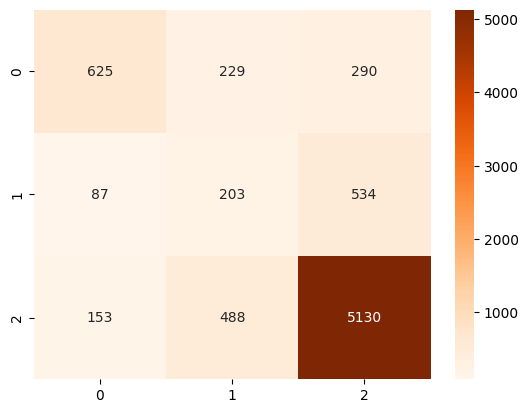

In [347]:
#Confusion matrix using pandas crosstab
conf_matrix = confusion_matrix(y_test, predictions)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Oranges, fmt='g')

# labels, title and ticks
#ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);